# Local to global N input modelling

In [ ]:
library(magrittr)
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'tidyr'

The following object is masked from 'package:magrittr':

    extract

here() starts at C:/Users/treimer/Documents/R-temp-files/local_to_global_mariculture_modelling


Attaching package: 'cowplot'

The following object is masked from 'package:ggpubr':

    get_legend


Attaching package: 'patchwork'

The following object is masked from 'package:cowplot':

    align_plots

qs 0.27.3. Announcement: https://github.com/qsbase/qs/issues/103


Attaching package: 'arrow'

The following object is masked from 'package:magrittr':

    is_in

The following object is masked from 'package:utils':

    timestamp

Linking to GEOS 3.13.0, GDAL 3.10.1, PROJ 9.5.1; sf_use_s2() is TRUE

terra 1.8.54


Attaching package: 'terra'

The following object is masked from 'package:arrow':

    buffer

The following object is masked from 'package:patchwork':

    area

The following object is masked from 'package:ggpubr':

    rotate

The following object is masked from 'package:tidyr':

    extract

The following objects are masked from 'package:magrittr':

    extract, inset


Attaching package: 'rnaturalearthdata'

The following object is masked from 'package:rnaturalearth':

    countries110

Loading required package: future


Attaching package: 'purrr'

The following object is masked from 'package:magrittr':

    set_names

udunits database from C:/Users/treimer/AppData/Local/R/cache/R/renv/cache/v5/windows/R-4.4/x86_64-w64-mingw32/units/0.8-7/5d0b024902d5da97a2b64f002e92a869/units/share/udunits/udunits2.xml

In [ ]:
source(here("00_model_functions.R"))
source(here("00_dirs.R"))

# Filenames
farm_coords_file <- file.path(output_farm_data_path, "farm_coords.qs")
species_params_file <- file.path(output_species_data_path, "species_params.qs")
pop_params_file <- file.path(output_species_data_path, "pop_params.qs")
feed_params_file <- file.path(output_species_data_path, "feed_params.qs")
sens_params_file <- file.path(output_species_data_path, "sens_params.qs")
sens_results_files <- file.path(output_sens_data_path) %>% list.files(full.names = T) %>% str_subset("results")

species_params <- qread(species_params_file)
pop_params <- qread(pop_params_file)

prettyplot <- function() {
  theme_classic() +
    theme(legend.position = "none",
          text = element_text(family = "serif", size = 12, colour = "black"),
          axis.title.x = element_text(vjust = 0.5),
          axis.title.y = element_text(hjust = 0.5))
}
  
feed_pal <- c("past" = "#E41A1C", "reference" = "#377EB8", "future" = "#4DAF4A")  
cohort_pal <- c("1" = "#E41A1C", "2" = "#377EB8", "3" = "#4DAF4A", "all" = "black")
macro_pal <- c(
  "protein" = "darkred", "P" = "darkred", 
  "carbohydrates" = "steelblue", "C" = "steelblue", 
  "lipids" = "darkgoldenrod1", "L" = "darkgoldenrod1"
)

This document was last updated at 15:42 on 12 Jun, 2025.

# Methods

### Feeding rate

To detail here:

-   Functional response to temperature (species-specific)
-   Overfeeding parameters and how they come into play
-   Deminstration of how feeding response and actual food given vary with temperature?

In [ ]:
df <- data.frame(water_temp = seq(-5, 26, 0.25))
df$feeding <- sapply(FUN = feeding_rate, X = df$water_temp, species_params = species_params)
df <- df %>% 
mutate(ing_pot = pop_params['meanImax'] * (pop_params['meanW']^species_params['m']) * feeding,
       food_prov = NA)
for (i in 1:nrow(df)) {
  df$food_prov[i] <- food_prov_rate(pop_params = pop_params, rel_feeding = df$feeding[i], ing_pot = df$ing_pot[i], 
                                    ing_pot_10 = pop_params['meanImax'] * (pop_params['meanW']^species_params['m']) * 0.1)
}
df$ing_pot <- df$ing_pot/maxna(df$ing_pot)
df$food_prov <- df$food_prov/maxna(df$ing_pot)

df %>% 
  ggplot(aes(x = water_temp, y = ing_pot)) +
  geom_line(linewidth = 0.75) +
  geom_line(aes(y = food_prov), linewidth = 0.75, linetype = "dotted") +
  scale_y_continuous(breaks = seq(0,1.5,0.25)) +
  scale_x_continuous(breaks = seq(-5,30,5), limits = c(-5,26)) +
  labs(x = expression("Water temperature ("*degree*"C)"), y = "Relative food ingested/provided") +
  prettyplot() +
  theme(text = element_text(colour = "black", family = "serif", size = 12))

## Farm temperature forcings

In [ ]:
farms_to_omit <- file.path(input_farm_coords_path, "atlantic_salmon_farms_to_omit.qs") %>% qs::qread()
farm_ts_data <- file.path(output_farm_data_path, "farm_ts_data.qs") %>% qs::qread()
farm_coords <- file.path(output_farm_data_path, "farm_coords.qs") %>% qs::qread() %>% 
    mutate(hemisphere = case_when(lat < 0 ~ "S", T ~ "N") %>% as.factor()) 

farms_geometry <- file.path(output_farm_data_path, "farm_geometry.qs") %>% qs::qread() %>% 
  rename(farm_ID = farm_id)

sorted_countries <- farm_coords %>% 
  merge(farms_geometry, by = "farm_ID") %>% 
  group_by(country) %>% 
  reframe(av_lat = mean(lat)) %>% 
  arrange(-av_lat) %>% 
  pull(country) %>% 
  unique()

farms_geometry <- farms_geometry %>% 
  mutate(country = factor(country, levels = sorted_countries))

In [ ]:
farm_temp_means <- farm_ts_data %>% 
  group_by(farm_ID) %>% 
  reframe(mean_temp = mean(temp_c)) %>% 
  merge(farms_geometry, by = "farm_ID") %>% 
  merge(farm_coords, by = "farm_ID") %>% 
  dplyr::filter(!farm_ID %in% farms_to_omit)

overall_mean <- mean(farm_temp_means$mean_temp)
overall_sd <- sd(farm_temp_means$mean_temp)

rm(farm_ts_data)

Mean daily temperatures at the farms globally ranged from from 6$^{\circ}$C to 16.7$^{\circ}$C, with an overall mean of 10.1$^{\circ}$C ($\pm$ 1.8$^{\circ}$C SD). Farms with a mean temperature of \$$6$^\$C were excluded (4 farms). The total number of farms included in the analysis was therefore 2717.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

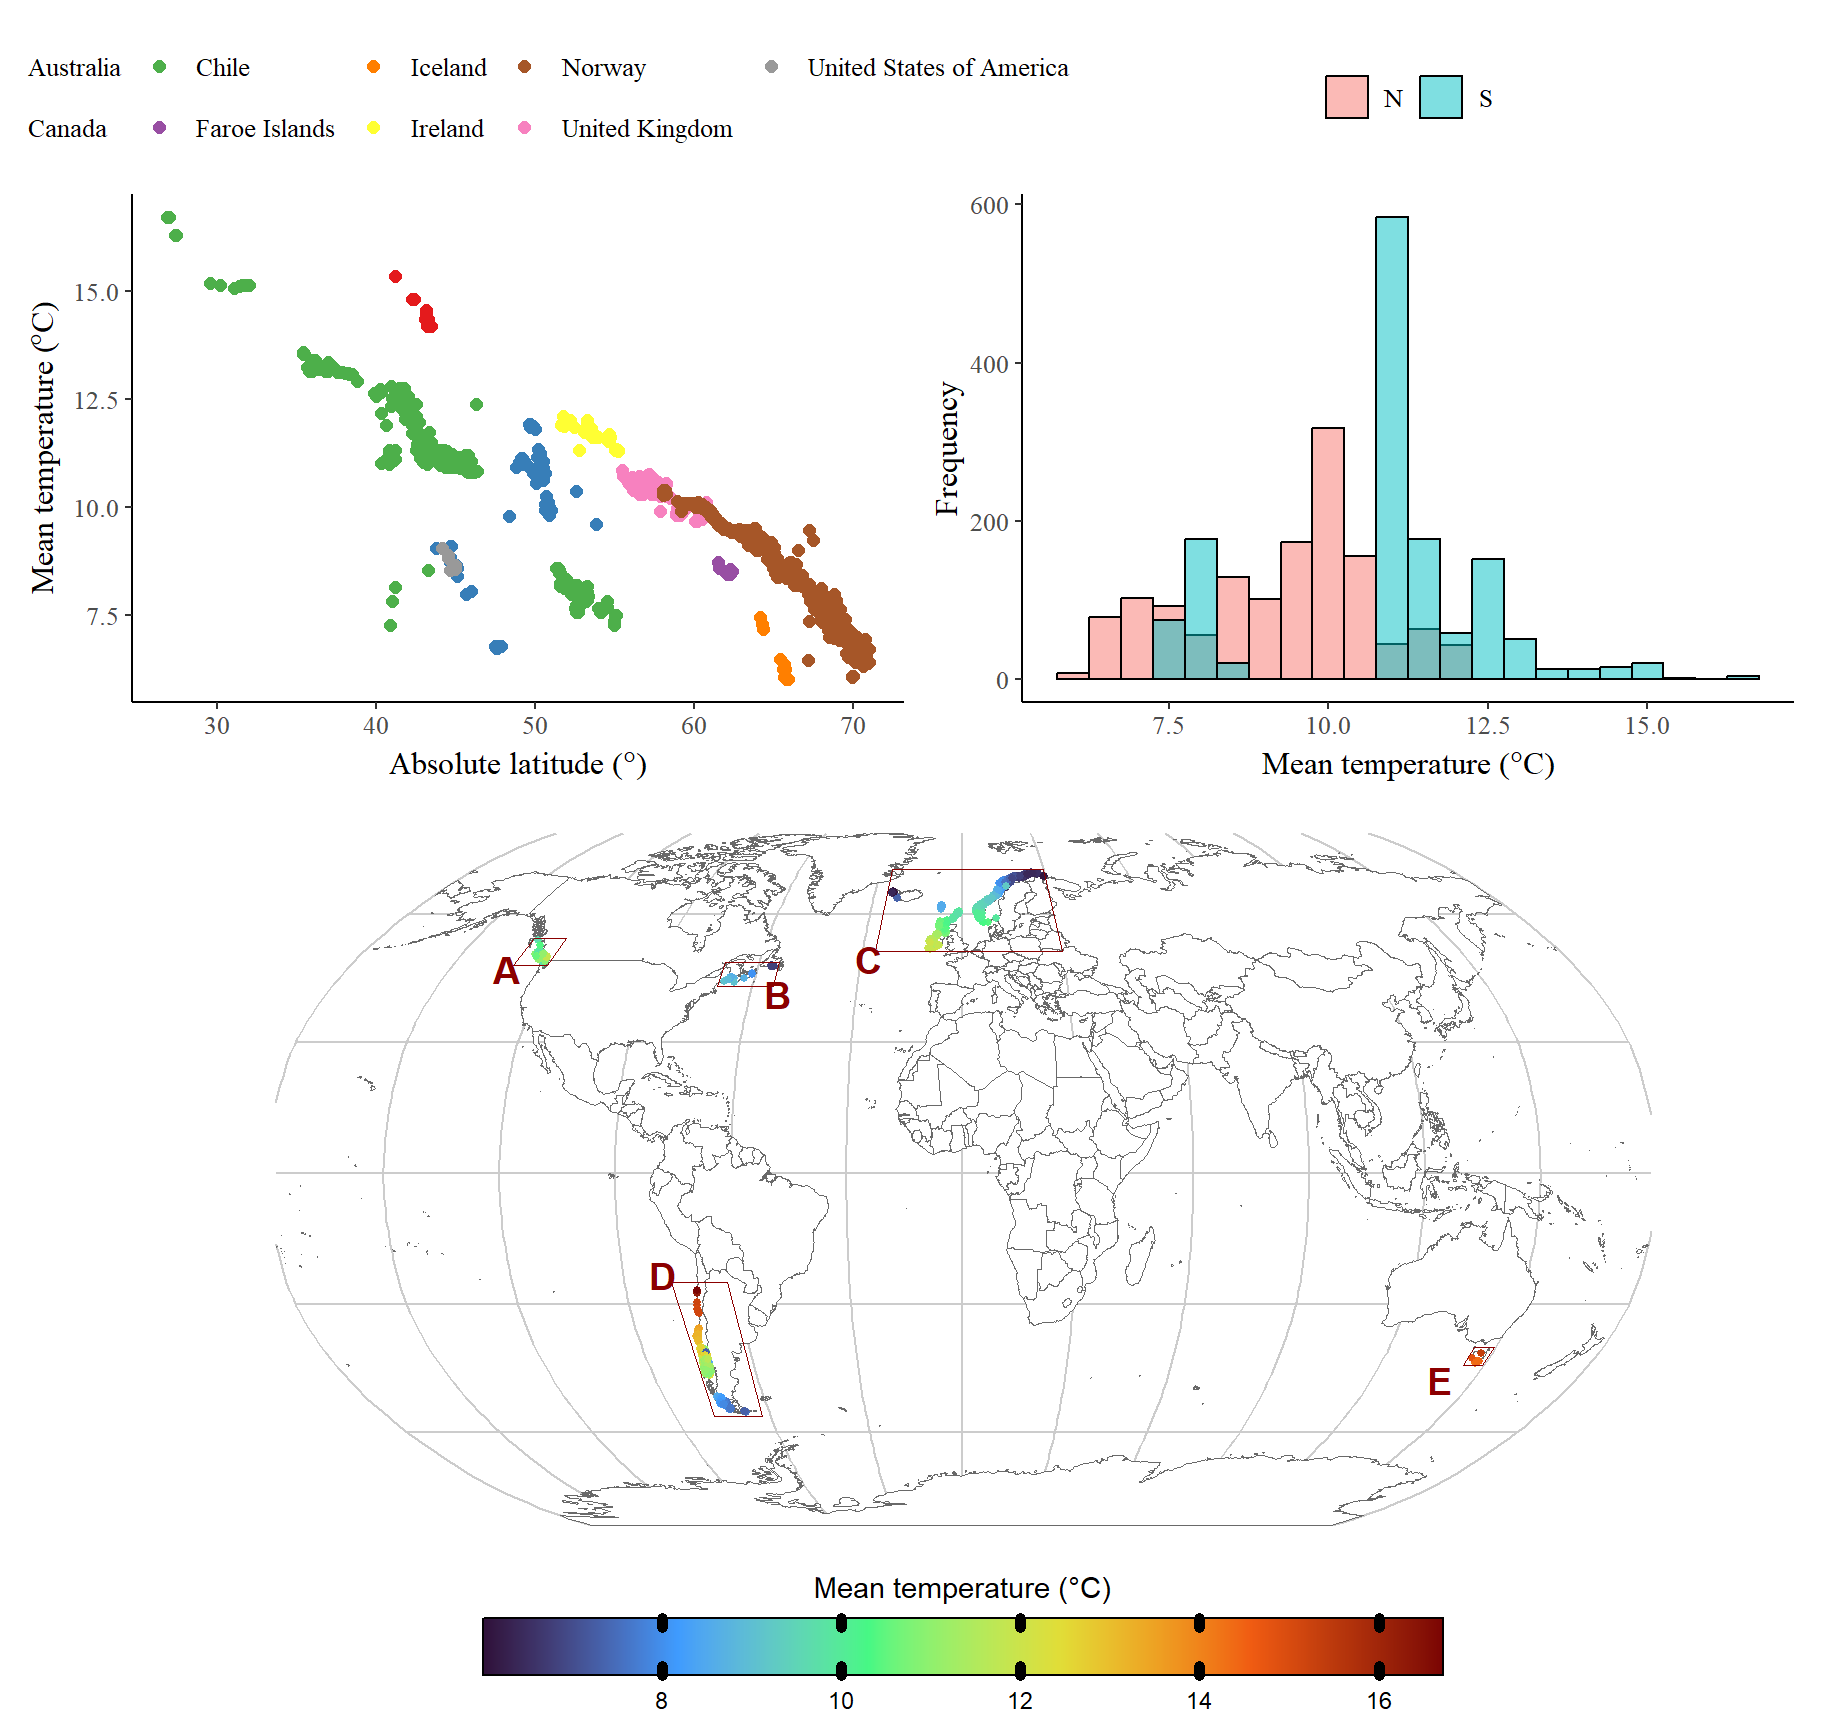

In [ ]:
worldmap <- ne_countries(scale = "medium", returnclass = "sf") %>% st_transform(crs = "+proj=robin")
graticules <- st_graticule(worldmap, lon = seq(-180, 180, 30), lat = seq(-90, 90, 30)) 

inset_boxes <- list(   # lonmin, lonmax, latmin, latmax
  CAN1 = c(-132, -122, 47.75, 54.25),
  CAN2 = c(-70, -54, 43, 48.5),
  EUR = c(-26, 30, 51, 72),
  CHI = c(-77.5, -62.5, -56, -25),
  AUS = c(144, 149.5, -44, -39.75)
)
labels_spec <- c(CAN1 = "bottom_left_outside", CAN2 = "bottom_right_outside", EUR = "bottom_left_outside", CHI = "top_left_outside", AUS = "bottom_left_outside")
labels_offset <- c(CAN1 = 1, CAN2 = 2, EUR = 1.75, CHI = 1.75, AUS = 3.5)

box_data <- create_boxes(box_list = inset_boxes, # see function create_boxes above
                         label_positions = unname(labels_spec),
                         offset_deg = unname(labels_offset))
boxes_robinson <- st_transform(box_data$boxes, crs = "+proj=robin")
labels_robinson <- st_transform(box_data$labels, crs = "+proj=robin")
farm_temp_robinson <- st_sf(farm_temp_means) %>% st_transform(crs = "+proj=robin")

p_big_map <- ggplot() +
  geom_sf(data = graticules, color = "gray80", size = 0.3) +
  geom_sf(data = worldmap, fill = "white", color = "dimgray") +
  geom_sf(data = farm_temp_robinson, aes(color = mean_temp), size = 1) +
  coord_sf() +
  scale_color_viridis_c(option = "turbo") +
  guides(col = guide_colourbar(
    title = "Mean temperature (°C)",
    direction = "horizontal", position = "bottom",
    label.position = "bottom", title.position = "top", 
    title.vjust = 1, title.hjust = 0.5,
    frame.colour = "black", ticks.colour = "black",ticks.linewidth = 2,
    barwidth = 25,barheight = 1.5
  )) +
  geom_sf(data = boxes_robinson, fill = NA, color = "darkred", size = 1.65) +
  geom_sf_text(data = labels_robinson, aes(label = letter), 
               color = "darkred", size = 5, fontface = "bold", 
               hjust = 0.5, vjust = 0.5) +
  theme_void()

In [ ]:
no_margins <- function() {
  theme(legend.position = "none", 
        plot.margin = margin(0, 0, 0, 0),
        axis.title = element_blank())
}

inset_boxes_sm <- list(   # lonmin, lonmax, latmin, latmax
  CAN1 = c(-132, -122, 48.5, 54),
  CAN2 = c(-70, -54, 43, 48.5),
  EUR = c(-23, 28.5, 52, 71),
  CHI = c(-78, -62, -55.5, -27),
  AUS = c(144, 149, -43.75, -40.75)
)

inset_boxes_sm <- map(inset_boxes_sm, function(bx) {
  list(
    xlims = bx[1:2],
    ylims = bx[3:4],
    labx = bx[1],
    laby = bx[4]
    )
})

worldmap <- ne_countries(scale = "large", returnclass = "sf")
p1 <- ggplot() +
  geom_sf(data = worldmap, fill = "white", color = "dimgray") +
  geom_sf(data = farm_temp_means, aes(color = mean_temp, geometry = geometry), size = 2) +
  coord_sf() +
  scale_color_viridis_c(option = "turbo") +
  guides(col = guide_colourbar(
    title = "Mean temperature (°C)",
    direction = "vertical", position = "right",
    label.position = "right", title.position = "top", 
    title.vjust = 1, title.hjust = 0.5,
    frame.colour = "black", ticks.colour = "black",ticks.linewidth = 2,
    barwidth = 1.5, barheight = 20
  )) +
  prettyplot() +
  labs(y = "Latitude", x = "Longitude")

p_Can1 <- p1 + 
  coord_sf(xlim = inset_boxes_sm[["CAN1"]][["xlims"]], 
           ylim = inset_boxes_sm[["CAN1"]][["ylims"]])  +
  draw_label("A", size = 14, fontface = "bold", 
             x = inset_boxes_sm[["CAN1"]][["labx"]], 
             y = inset_boxes_sm[["CAN1"]][["laby"]], 
             hjust = -1, vjust = 0.5)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

## Model parameterisation

In [ ]:
params <- file.path(output_species_data_path, "sens_params.qs") %>% qs::qread()

param_names <- tibble::tribble(
  ~name,        ~lab,
  "alpha",      bquote(alpha),
  "epsprot",    bquote(epsilon["P"]),
  "epslip",     bquote(epsilon["L"]),
  "epscarb",    bquote(epsilon["C"]),
  "epsO2",      bquote(epsilon["O"[2]]),
  "pk",         bquote("pk"),
  "k0",         bquote("k"[0]),
  "m",          bquote("m"),
  "n",          bquote("n"),
  "betac",      bquote(beta*"C"),
  "Tma",        bquote("T"["max"]),
  "Toa",        bquote("T"["opt"]),
  "Taa",        bquote("T"["min"]),
  "omega",      bquote(omega),
  "a",          bquote("a"),
  "k",          bquote("k"),
  "eff",        bquote("eff"),
  "meanW",      bquote(bar("W")),
  "deltaW",     bquote(Delta*"W"), 
  "meanImax",   bquote(bar("I"["max"])),
  "deltaImax",  bquote(Delta*"I"["max"]),
  "overFmean",  bquote(bar("F")),
  "overFdelta", bquote(Delta*"F"),
  "mortmyt",    bquote("mort")
)

|      Parameter       |    Value     |          Reference          |
|:--------------------:|:------------:|:---------------------------:|
|       $\alpha$       |     0.04     | @broekhuizen_modelling_1994 |
|    $\epsilon_{P}$    |   2.36^{4}   |       @baldan_r_2018        |
|    $\epsilon_{L}$    |   3.62^{4}   |       @baldan_r_2018        |
|    $\epsilon_{C}$    |   1.72^{4}   |       @baldan_r_2018        |
|   $\epsilon_{O_2}$   |   1.34^{4}   |    @elliott_energy_1975     |
|        $p_k$         |     0.05     |   @macnaughton_using_2019   |
|        $k_0$         |    0.003     |   @macnaughton_using_2019   |
|         $m$          |     0.75     | @broekhuizen_modelling_1994 |
|         $n$          |      1       |       @baldan_r_2018        |
|      $\beta C$       |    0.3234    |    @jonsson_thermal_2001    |
|      $T_{max}$       |      26      |    @poletto_unusual_2017    |
|      $T_{opt}$       |      16      |    @jonsson_thermal_2001    |
|      $T_{min}$       |      2       | @vadboncoeur_lowering_2023  |
|       $\omega$       |    0.6542    |       @baldan_r_2018        |
|         $a$          |     2669     | @van_tien_development_2016  |
|         $k$          |    0.1715    | @van_tien_development_2016  |
|        $eff$         |     0.97     |      @uglem_does_2020       |
|    $\overline{W}$    |     125      |  @dempsey_estimating_2023   |
|     $\Delta{W}$      |      10      |  @dempsey_estimating_2023   |
| $\overline{I_{max}}$ |    0.035     |    @lall_nutrition_2009     |
|  $\Delta{I_{max}}$   |    0.005     |    @lall_nutrition_2009     |
|    $\overline{F}$    |    0.015     |                             |
|     $\Delta{F}$      |    0.0045    |                             |
|        $mort$        | 5.99798^{-4} |     @tvete_towards_2023     |

### Parameter sensitivity

Parameter sensitivity was tested by varying each parameter in @tbl-params by $\pm 10$% and calculating sensitivity as $S_p = \frac{(P_{1.1} - P_{0.9})}{0.2 \times P_1}$, where $S$ is the sensitivity of the measured variable to changes in parameter $p$, and $P_{1.1}$, $P_{0.9}$, and $P_{1}$ are the value of the measured variable when the model is run with parameter $p$ at 110%, 90%, and 100% of its value respectively. All parameters in Table @tbl-params were tested. The population-level parameters ($\overline{W}$, $\Delta{W}$, $\overline{I_{max}}$, $\Delta{I_{max}}$, $\overline{F}$, $\Delta{F}$) were tested with a population of of 5000 on a random 10% of farms, while all other parameters were tested across all farms with a population of 10.

## Modelled experimental feeds

In [ ]:
feed_params <- file.path(output_species_data_path, "feed_params.qs") %>%
  qs::qread() 

feed_summary <- map_dfr(names(feed_params), function(feed) {
  df <- feed_params[[feed]]
  map_dfr(c("Proteins", "Lipids", "Carbohydrates"), function(macro) {
    contrib <- df[[macro]]$proportion * df[[macro]]$macro
    total <- sum(contrib)
    digest <- sum(df[[macro]]$digest * contrib) / total
        tibble(
      feed = feed,
      macro = macro,
      total = total,
      digest = digest
    )
  })
}) %>%
  mutate(macro = factor(macro, levels = c("Proteins", "Lipids", "Carbohydrates"), labels = c("P", "L", "C")),
         feed = factor(feed, levels = c("reference", "past", "future")),
         total_r = total * 100 %>% round(1),
         digest_r = digest * 100 %>% round(1))

The reference feed was 37.8% protein, 36.5% lipid, and 20.4% carbohydrate, the past feed was 49.8% protein, 27.1% lipid, and 16.6% carbohydrate, and the future feed was 47.7% protein, 32.9% lipid, and 13.9% carbohydrate.

Ingredients are tracked seperately through the model with their own digestibility coefficients. Overall, protein digestibility was 89.2%, 90.5%, and 86.2% and carbohydrate digestibility was 69.6%, 79.7%, and 69.3% within the reference, past, and future feeds respectively. The digestibility of lipids was assumed to remain constant across all ingredients at 96%.

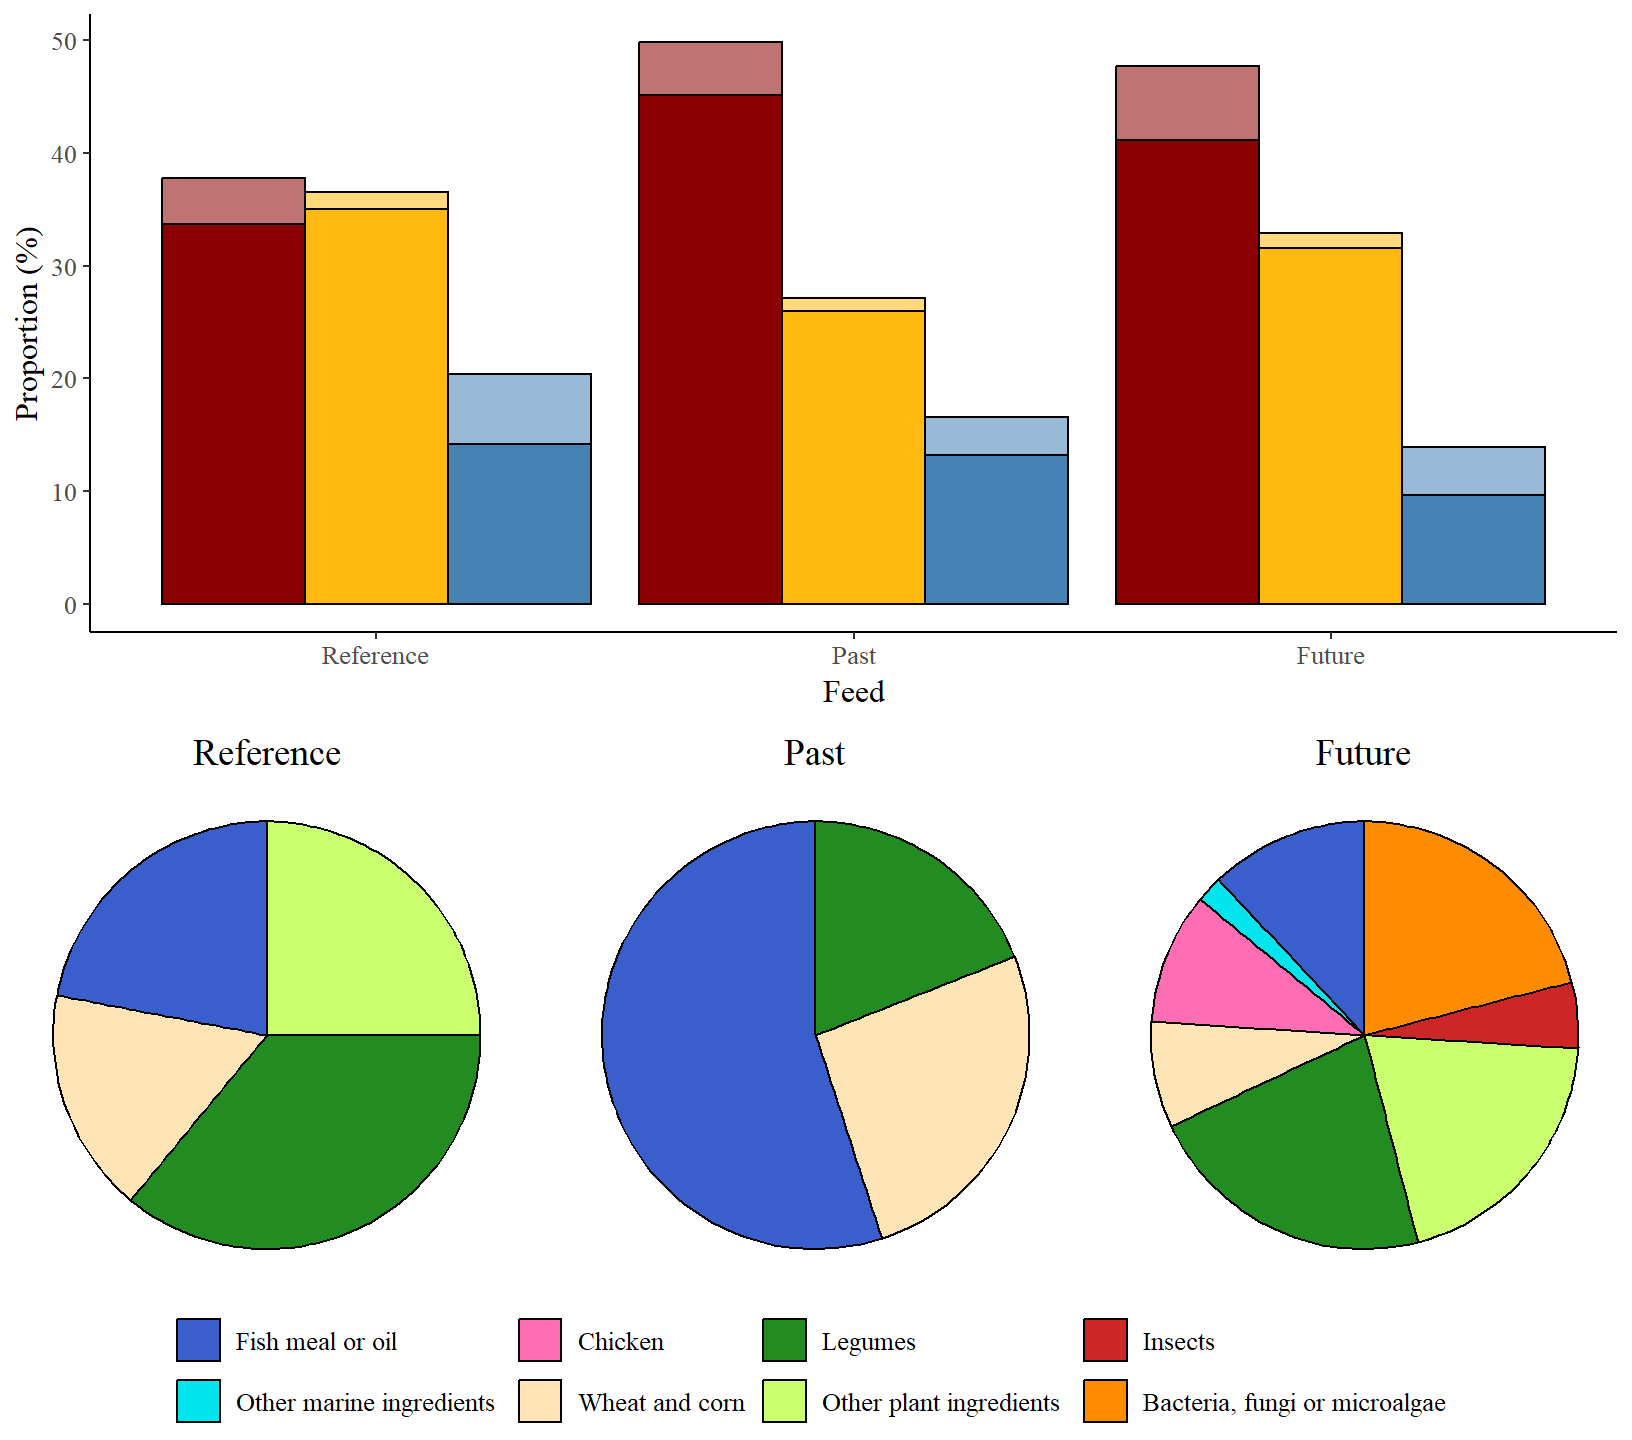

In [ ]:
p1 <- feed_summary %>%
  mutate(digest_total = digest * total) %>% 
  ggplot(aes(x = feed, y = total, fill = macro)) +
  geom_col(position = "dodge", alpha = 0.55, colour = "black") +
  geom_col(mapping = aes(y = digest_total), position = "dodge", alpha = 1, colour = "black") +
  scale_fill_manual(values = macro_pal) +
  scale_y_continuous(breaks = seq(0,0.5,0.1), labels = seq(0,50,10)) +
  scale_x_discrete(labels = c("reference" = "Reference", "past" = "Past", "future" = "Future")) +
  labs(x = "Feed", y = "Proportion (%)") +
  prettyplot()

feed_ings <- rbind(
  feed_params[[1]][[1]] %>% mutate(feed = as.factor("reference")), 
  feed_params[[2]][[1]] %>% mutate(feed = as.factor("past")), 
  feed_params[[3]][[1]] %>% mutate(feed = as.factor("future"))
) %>%
  rename(protein = macro) %>%
  mutate(
    category = case_when(
      str_detect(ingredient, "fish-oil") ~ "fish",
      str_detect(ingredient, "fishmeal") ~ "fish",
      str_detect(ingredient, "krill") ~ "other-marine",
      str_detect(ingredient, "soy") ~ "legume",
      str_detect(ingredient, "pea") ~ "legume",
      str_detect(ingredient, "guar") ~ "legume",
      str_detect(ingredient, "faba") ~ "legume",
      str_detect(ingredient, "corn") ~ "wheat-corn",
      str_detect(ingredient, "wheat") ~ "wheat-corn",
      str_detect(ingredient, "chicken") ~ "chicken",
      str_detect(ingredient, "bacteri") ~ "bact-fungi-micro",
      str_detect(ingredient, "yeast") ~ "bact-fungi-micro",
      str_detect(ingredient, "spirulina") ~ "bact-fungi-micro",
      str_detect(ingredient, "bsf") ~ "insect",
      T ~ "other-plant"
    ) %>% 
      factor(levels = c("fish", "other-marine", "chicken", "wheat-corn", "legume", "other-plant", "insect", "bact-fungi-micro"))
  )

p_ings <- feed_ings %>% 
  mutate(feed = factor(feed, levels = c("reference", "past", "future"), labels = c("Reference", "Past", "Future"))) %>% 
  group_by(feed, category) %>%
  reframe(proportion = sum(proportion)) %>% 
  ggplot(aes(x = "", y = proportion, fill = category)) +
  geom_col(width = 1, colour = "black") +
  coord_polar("y", start = 0) +
  scale_fill_manual(
    name = "Ingredient category",
    values = c("fish" = "royalblue3", "other-marine" = "turquoise2", "chicken" = "hotpink1", "wheat-corn" = "moccasin", "legume" = "forestgreen", "other-plant" = "darkolivegreen1", "insect" = "firebrick3", "bact-fungi-micro" = "darkorange"), 
    labels = c("Fish meal or oil", "Other marine ingredients", "Chicken", "Wheat and corn", "Legumes", "Other plant ingredients", "Insects", "Bacteria, fungi or microalgae")) +
  facet_grid(cols = vars(feed)) +
  theme_void() +
  theme(
    text = element_text(family = "serif", size = 12, colour = "black"),
    legend.position = "bottom",
    legend.title = element_blank(), 
    strip.text = element_blank(),
    strip.text.x = element_text(size = 14)
  )

plot_grid(p1, p_ings, nrow = 2)

## Model population and biomass

In [ ]:
farmrun_files <- file.path(output_cohorts_data_path) %>% 
  list.files(full.names = T)

weight <- find_read(output_cohorts_data_path, "allfarms_comparisons_weight_stat")
biomass <- find_read(output_cohorts_data_path, "allfarms_comparisons_biomass_stat")

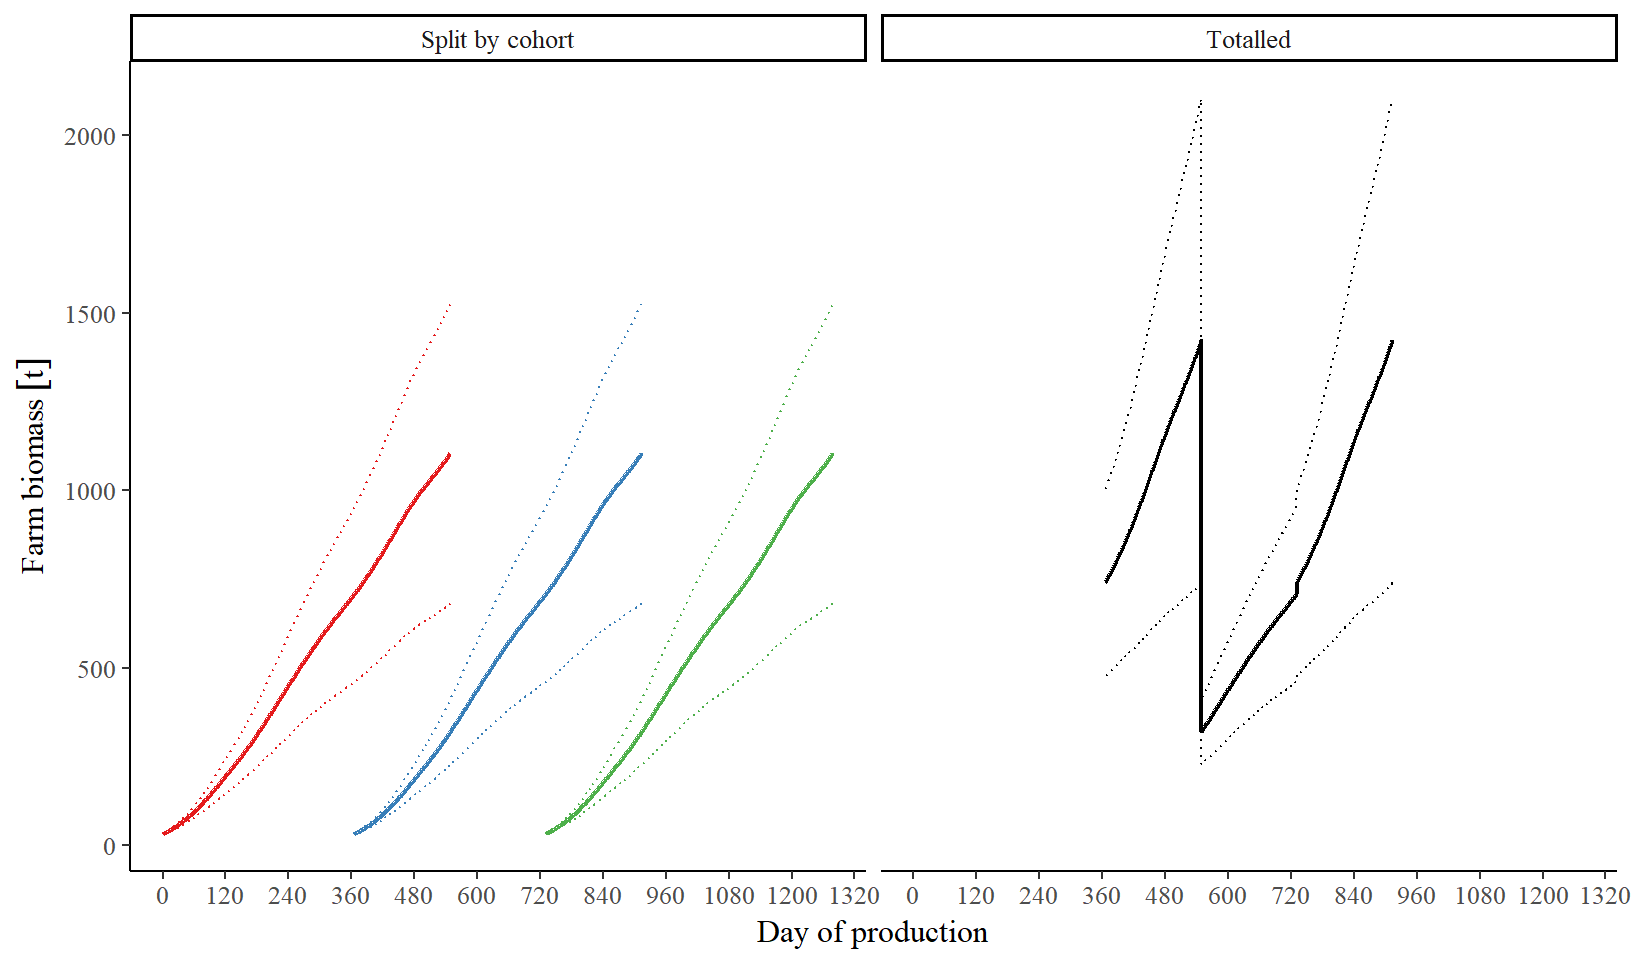

In [ ]:
fnms <- output_growth_data_path %>% 
  list.files(full.names = T) %>% 
  str_subset("reference")

df <- qs::qread(fnms[1])[["biomass_stat"]] %>% 
  as.data.frame() %>% 
  mutate(mean = set_units(mean, "g") %>% set_units("t"),
         sd = set_units(sd, "g") %>% set_units("t")) %>% 
  select(-farm_ID)

df <- rbind(
  df %>% mutate(cohort = 1),
  df %>% mutate(t = t+365, cohort = 2),
  df %>% mutate(t = t+730, cohort = 3)
) %>% 
  mutate(t = (t-min(t))+1,
         split = "Split by cohort")

min_t <- min(df$t[df$cohort == 2])
max_t <- max(df$t[df$cohort == 2])

df_2 <- df %>% 
  filter(t %in% min_t:max_t) %>% 
  mutate(sd = sd/mean) %>% 
  group_by(t) %>% 
  reframe(sd = sqrt(sum(sd^2)),
          mean = sum(mean),
          sd = sd*mean) %>% 
  mutate(cohort = "all",
         split = "Totalled")

df <- rbind(df, df_2) %>% 
  mutate(cohort = as.factor(cohort))

ggplot(df, aes(x = t, y = mean, ymin = mean-sd, ymax = mean+sd, colour = as.factor(cohort))) +
  geom_line(linewidth = 0.75) +
  geom_ribbon(linetype = "dotted", alpha = 0) +
  facet_grid(cols = vars(split)) +
  scale_x_continuous(breaks = seq(0, 1600, 120)) +
  scale_colour_manual(values = cohort_pal) +
  prettyplot() +
  labs(y = "Farm biomass", x = "Day of production")

In [ ]:
coho_biom <- file.path(data_analysis_path, "biomass_produced_comparison.qs") %>% 
  qs::qread()
harv_size <- file.path(output_farm_data_path, "farm_harvest_size.qs") %>% 
  qread()

coho_biom_summ <- coho_biom %>% 
  mutate(perc_diff = 100*(mean - tonnes_per_farm)/tonnes_per_farm)

Each farm’s final population was calculated by dividing the production tonnage required by the average modelled individual harvest size for each farm (when feed reference feed). A population timeseries was the generated using the standard mortality rate (5.99798^{-4} d$^{-1}$). Using this method, a farm’s ‘population’ is not a good representation of the actual number of individuals being farmed, but it ensures each farm location is producing the correct tonnage while allowing comparisons between the different feeds.

By this method, farm biomass as predicted by the model slightly overestimated farm tonnage. Predicted farm biomass was 2.4-6.5 higher than tonnage produced (@fig-biomass-produced). This variation was not correlated with mean farm temperature or total tonnage produced (@fig-biomass-variation).

## Impacts of nutrient input

General thoughts is that a risk-assessment approach is most compelling:

-   Hazard: Nutrient input. Present as a change between feeds (%?), relative to background levels (ratio?)
    -   Possibly ask Camille how the quotas for Tasmanian salmon are calculated
    -   Background levels are from [oceanhealthindex.org](https://knb.ecoinformatics.org/view/resource_map_doi:10.5063/F1610XPS) - double-check that it includes wastewater input AND agriculture - should include both - if they’re not combined ask Ben because he has them combined somewhere
    -   If this is too uncertain perhaps combine into categorical (oligotrophic/eutrophic) classification?
-   Exposure: Species presence. Use IUCN/Aquamap data to estimate the % of each species range is occupied by farms
    -   give each farm a 1km radius, check for overlaps
    -   Gage already has the data to process the Aquamap data
-   Vulnerability: species vulnerability to eutrophication + nutrient input - from @butt_trait-based_2022. Possibly also use IUCN threat levels for prioritisation?

# Statistical analysis & code availability

All analysis was conducted in R version 4.4.2 “Pile of Leaves” \[@R_base\]. Major packages used include packages `magrittr`, version 2.0.3 \[@magrittr\], `dplyr`, version 1.1.4 \[@dplyr\], `tidyr`, version 1.3.1 \[@tidyr\], `stringr`, version 1.5.1 \[@stringr\], `ggplot2`, version 3.5.2 \[@ggplot2\], `arrow`, version 20.0.0.2 \[@arrow\], `targets`, version 1.11.3 \[@targets\], `sf`, version 1.0.21 \[@sf\], `terra`, version 1.8.54 \[@terra\], `rnaturalearth`, version 1.1.0 \[@rnaturalearth\], `furrr`, version 0.3.1 \[@furrr\], `future`, version 1.58.0 \[@future\], `units`, version 0.8.7 \[@units\], and `lubridate`, version 1.9.4 \[@lubridate\]. For a full list of R packages used see the lockfile on [Github](https://www.github.com). This manuscript was written in Quarto \[@quarto\] using TinyTex \[@tinytex\] and the acronyms extension \[@acronyms\].

# Results

-   Parameter sensitivity results are in supplementary @sec-parameter-sensitivity

In general, data outputs comes in the following dimensions:

-   Location -\> temperature -\> farm_ID
-   Uneaten feed + excreted faeces = total inputs (g)
-   Day of production (impacted by location)
-   Main point is the difference between feeds (kg/t salmon).
-   Also interesting to see if difference between feeds varies geographically (correlates with latitude, or maybe mean/median/max temperature?)

## Uneaten feed and faeces

In [ ]:
mass_inputs_ts <- find_read(data_analysis_path, "all_waste_inputs")
mass_inputs_end <- find_read(data_analysis_path, "sumtotal_waste_inputs.qs")
N_inputs_ts <- find_read(data_analysis_path, "all_N_inputs")
N_inputs_end <- find_read(data_analysis_path, "sumtotal_N_inputs")

In [ ]:
mass_inputs_ts
N_inputs_ts

# Through time
inputs_stats_ts <- inputs_df %>%
  group_by(feed, t, measure) %>% 
  reframe(min = minna(mean),
          max = maxna(mean),
          sd = sdna(mean) %>% set_units("g"),
          mean = meanna(mean))

inputs_stats_rel_ts <- inputs_rel_df %>% 
  group_by(feed, t, measure) %>% 
  reframe(min = minna(mean),
          max = maxna(mean),
          sd = sdna(mean) %>% set_units("g g_fish-1"),
          mean = meanna(mean))

# Total (at production end)
inputs_stats_end <- inputs_df %>% 
  group_by(feed, measure, farm_ID) %>% 
  reframe(mean = sumna(mean)) %>% 
  group_by(feed, measure) %>% 
  reframe(min = minna(mean),
          max = maxna(mean),
          sd = sdna(mean) %>% set_units("g"),
          mean = meanna(mean))

inputs_stats_rel_end <- inputs_rel_df %>% 
  group_by(feed, measure, farm_ID) %>% 
  reframe(mean = sumna(mean)) %>% 
  group_by(feed, measure) %>% 
  reframe(min = minna(mean),
          max = maxna(mean),
          sd = sdna(mean) %>% set_units("g g_fish-1"),
          mean = meanna(mean))

inputs_stats_rel_end_diff <- inputs_rel_df %>% 
  group_by(feed, measure, farm_ID) %>% 
  reframe(mean = sumna(mean)) %>% 
  pivot_wider(names_from = feed, values_from = mean) %>% 
  mutate(future = (future-reference)/reference,
         past = (past-reference)/reference) %>% 
  select(-reference) %>% 
  pivot_longer(cols = c(past, future), names_to = "feed", values_to = "diff") %>% 
  mutate(feed = factor(feed, levels = c("past", "future"))) %>% 
  group_by(feed, measure) %>% 
  reframe(min = minna(diff),
          max = maxna(diff),
          sd = sdna(diff),
          mean = meanna(diff))

# Pull key values (uneaten feed)
u_stmin1 <- filter(inputs_stats_rel_end, feed == "reference", measure == "uneat") %>% pull(min)
u_stmax1 <- filter(inputs_stats_rel_end, feed == "reference", measure == "uneat") %>% pull(max)
u_stmean1 <- filter(inputs_stats_rel_end, feed == "reference", measure == "uneat") %>% pull(mean)
u_stmin2 <- filter(inputs_stats_rel_end_diff, feed == "past", measure == "uneat") %>% pull(min)
u_stmax2 <- filter(inputs_stats_rel_end_diff, feed == "past", measure == "uneat") %>% pull(max)
u_stmean2 <- filter(inputs_stats_rel_end_diff, feed == "past", measure == "uneat") %>% pull(mean)
u_stmin3 <- filter(inputs_stats_rel_end_diff, feed == "future", measure == "uneat") %>% pull(min)
u_stmax3 <- filter(inputs_stats_rel_end_diff, feed == "future", measure == "uneat") %>% pull(max)
u_stmean3 <- filter(inputs_stats_rel_end_diff, feed == "future", measure == "uneat") %>% pull(mean)

# Convert past and future values to % change values
u_stmin2 <- (100*u_stmin2) %>% round(2)
u_stmax2 <- (100*u_stmax2) %>% round(2)
u_stmean2 <- (100*u_stmean2) %>% round(2)
u_stmin3 <- (100*u_stmin3) %>% round(2)
u_stmax3 <- (100*u_stmax3) %>% round(2)
u_stmean3 <- (100*u_stmean3) %>% round(2)

u_stmin1 <- u_stmin1 %>% set_units("g kg_fish-1") %>% drop_units() %>% round(2)
u_stmax1 <- u_stmax1 %>% set_units("g kg_fish-1") %>% drop_units() %>% round(2)
u_stmean1 <- u_stmean1 %>% set_units("g kg_fish-1") %>% drop_units() %>% round(2)

# Pull key values (excreted faeces)
e_stmin1 <- filter(inputs_stats_rel_end, feed == "reference", measure == "excr") %>% pull(min)
e_stmax1 <- filter(inputs_stats_rel_end, feed == "reference", measure == "excr") %>% pull(max)
e_stmean1 <- filter(inputs_stats_rel_end, feed == "reference", measure == "excr") %>% pull(mean)
e_stmin2 <- filter(inputs_stats_rel_end_diff, feed == "past", measure == "excr") %>% pull(min)
e_stmax2 <- filter(inputs_stats_rel_end_diff, feed == "past", measure == "excr") %>% pull(max)
e_stmean2 <- filter(inputs_stats_rel_end_diff, feed == "past", measure == "excr") %>% pull(mean)
e_stmin3 <- filter(inputs_stats_rel_end_diff, feed == "future", measure == "excr") %>% pull(min)
e_stmax3 <- filter(inputs_stats_rel_end_diff, feed == "future", measure == "excr") %>% pull(max)
e_stmean3 <- filter(inputs_stats_rel_end_diff, feed == "future", measure == "excr") %>% pull(mean)

# Convert past and future values to % change values
e_stmin2 <- (100*e_stmin2) %>% round(2)
e_stmax2 <- (100*e_stmax2) %>% round(2)
e_stmean2 <- (100*e_stmean2) %>% round(2)
e_stmin3 <- (100*e_stmin3) %>% round(2)
e_stmax3 <- (100*e_stmax3) %>% round(2)
e_stmean3 <- (100*e_stmean3) %>% round(2)

e_stmin1 <- e_stmin1 %>% set_units("g kg_fish-1") %>% drop_units() %>% round(2)
e_stmax1 <- e_stmax1 %>% set_units("g kg_fish-1") %>% drop_units() %>% round(2)
e_stmean1 <- e_stmean1 %>% set_units("g kg_fish-1") %>% drop_units() %>% round(2)

In [ ]:
mass_inputs_sep <- mass_inputs_end %>% 
  mutate(waste_per_biomass = set_units(total/biomass_total, "g kg_fish-1")) %>% 
  dplyr::select(-c(total, biomass_total)) %>% 
  pivot_wider(names_from = measure, values_from = waste_per_biomass) %>% 
  mutate(total = excr+uneat) %>% 
  pivot_longer(names_to = "measure", values_to = "waste_per_biomass", cols = c(total, excr, uneat), names_transform = list(measure = as.factor)) %>% 
  group_by(feed, measure) %>% 
  reframe(mean_wpb = meanna(waste_per_biomass),
          mean_wpb = sdna(waste_per_biomass) %>% set_units("g kg_fish-1"),
          min_wpb = minna(waste_per_biomass),
          max_wpb = maxna(waste_per_biomass))

twi_min <- mass_inputs_sep$min_wpb[mass_inputs_sep$measure == "total"] %>% round(2)
twi_max <- mass_inputs_sep$max_wpb[mass_inputs_sep$measure == "total"] %>% round(2)
twi_mean <- mass_inputs_sep$mean_wpb[mass_inputs_sep$measure == "total"] %>% round(2)

# There were only very small differences in total uneaten feed between the different feeds, with the past feed increasing uneaten feed by `r u_stmin2`-`r u_stmax2`%  (mean of `r u_stmean2`%) and the future feed increasing uneaten feed by `r u_stmin3`-`r u_stmax3`%  (mean of `r u_stmean3`%).

# * Total excreted faeces across a cohort fed the reference feed ranged from `r e_stmin1` to `r e_stmax1` g kg$^{-1}$ fish, with a mean of `r e_stmean1` g kg$^{-1}$ fish. 
# * Past feed decreased excreted faeces by `r -1*e_stmin2`-`r -1*e_stmax2`%  (mean of `r -1*e_stmean2`%) 
# * Future feed increased excreted faeces by `r e_stmin3`-`r e_stmax3`%  (mean of `r e_stmean3`%)

-   Total waste inputs across a single production period of fish fed the reference feed ranged from 151.45 to 252.66 g kg$^{-1}$ fish, with a mean of 15.74 g kg$^{-1}$ fish.
-   Total waste inputs across a single production period of fish fed the past feed ranged from 127.58 to 213.51 g kg$^{-1}$ fish, with a mean of 13.31 g kg$^{-1}$ fish.
-   Total waste inputs across a single production period of fish fed the future feed ranged from 157.16 to 262.39 g kg$^{-1}$ fish, with a mean of 16.35 g kg$^{-1}$ fish.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

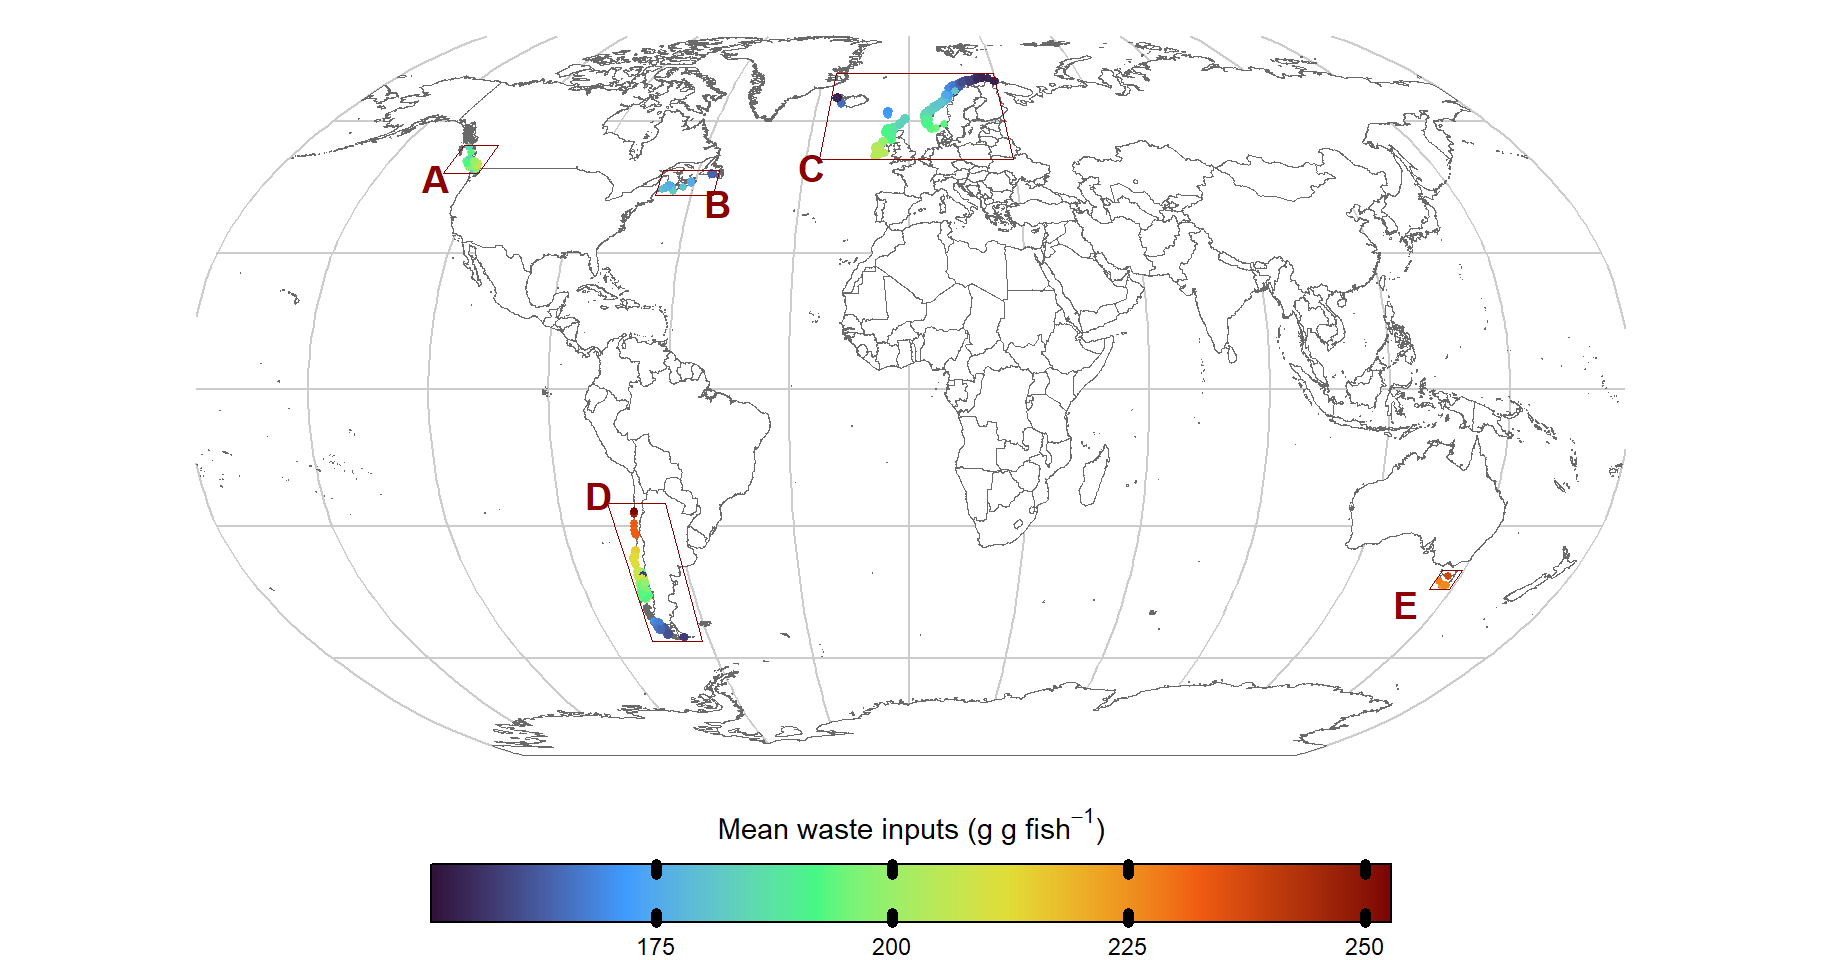

In [ ]:
mass_inputs_sep_geometry <- mass_inputs_end %>% 
  mutate(waste_per_biomass = set_units(total/biomass_total, "g kg_fish-1")) %>% 
  dplyr::select(-c(total, biomass_total)) %>% 
  pivot_wider(names_from = measure, values_from = waste_per_biomass) %>% 
  mutate(total = excr+uneat) %>% 
  pivot_longer(names_to = "measure", values_to = "waste_per_biomass", cols = c(total, excr, uneat), names_transform = list(measure = as.factor)) %>% 
  group_by(farm_ID, feed, measure) %>% 
  reframe(mean_wpb = meanna(waste_per_biomass),
          sd_wpb = sdna(waste_per_biomass) %>% set_units("g kg_fish-1"),
          min_wpb = minna(waste_per_biomass),
          max_wpb = maxna(waste_per_biomass)) %>% 
  merge(farms_geometry, by = "farm_ID")

mass_inputs_robinson <- mass_inputs_sep_geometry %>% 
  filter(feed == "reference" & measure == "total") %>% 
  mutate(mean_wpb = mean_wpb %>% drop_units()) %>% 
  st_sf() %>% 
  st_transform(crs = "+proj=robin")

ggplot() +
  geom_sf(data = graticules, color = "gray80", size = 0.3) +
  geom_sf(data = worldmap, fill = "white", color = "dimgray") +
  geom_sf(data = mass_inputs_robinson, aes(color = mean_wpb), size = 1) +
  coord_sf() +
  scale_color_viridis_c(option = "turbo") +
  guides(col = guide_colourbar(
    title = expression("Mean waste inputs (g g fish"^-1*")"),
    direction = "horizontal", position = "bottom",
    label.position = "bottom", title.position = "top", 
    title.vjust = 1, title.hjust = 0.5,
    frame.colour = "black", ticks.colour = "black",ticks.linewidth = 2,
    barwidth = 25,barheight = 1.5
  )) +
  geom_sf(data = boxes_robinson, fill = NA, color = "darkred", size = 1.65) +
  geom_sf_text(data = labels_robinson, aes(label = letter), 
               color = "darkred", size = 5, fontface = "bold", 
               hjust = 0.5, vjust = 0.5) +
  theme_void()

In [ ]:
mass_inputs_patch <- mass_inputs_sep_geometry %>% 
  filter(feed == "reference" & measure == "total") %>% 
  mutate(mean_wpb = mean_wpb %>% drop_units())

p1 <- ggplot() +
  geom_sf(data = worldmap, fill = "white", color = "dimgray") +
  geom_sf(data = mass_inputs_patch, aes(color = mean_wpb, geometry = geometry), size = 2) +
  coord_sf() +
  scale_color_viridis_c(option = "turbo") +
  guides(col = guide_colourbar(
    title = expression("Mean waste inputs (g g fish"^-1*")"),
    direction = "vertical", position = "right",
    label.position = "right", title.position = "top", 
    title.vjust = 1, title.hjust = 0.5,
    frame.colour = "black", ticks.colour = "black",ticks.linewidth = 1.5,
    barwidth = 1.5, barheight = 20,
  )) +
  prettyplot() +
  labs(y = "Latitude", x = "Longitude")

p_Can1 <- p1 + 
  coord_sf(xlim = inset_boxes_sm[["CAN1"]][["xlims"]], 
           ylim = inset_boxes_sm[["CAN1"]][["ylims"]])  +
  draw_label("A", size = 14, fontface = "bold", 
             x = inset_boxes_sm[["CAN1"]][["labx"]], 
             y = inset_boxes_sm[["CAN1"]][["laby"]], 
             hjust = -1, vjust = 0.5)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.

In [ ]:
excreted_total %>% 
  merge(farms_geometry, by = "farm_ID") %>% 
  mutate(excr_biom_mean = excr_biom_mean %>% set_units("g g_fish-1 d-1") %>% set_units("g kg_fish-1 d-1"),
         country = factor(country, levels = sorted_countries)) %>% 
  ggplot(aes(x = country, y = excr_biom_mean, fill = feed)) +
  geom_boxplot() +
  prettyplot() +
  scale_fill_manual(values = feed_pal) +
  labs(y = "Excreted faeces", x = "Country")

In [ ]:
df <- excreted_total %>% 
  select(-contains(c("sd", "excr_mean", "biomass"))) %>% 
  pivot_wider(names_from = "feed", values_from = "excr_biom_mean") %>% 
  mutate(past = past-reference,
         future = future-reference) %>% 
  pivot_longer(names_to = "feed", values_to = "diff", cols = c(past, future), names_transform = list(feed = as.factor)) %>% 
  mutate(reference = set_units(reference, "g kg_fish-1 d-1"),
         diff = set_units(diff, "kg t_fish-1 d-1")) %>% 
  merge(farm_coords, by = "farm_ID") %>% 
  mutate(prod_day = t-t_start+1)

summ <- df %>%
  group_by(hemisphere, feed) %>% 
  reframe(mean = meanna(diff) %>% round(3),
          min = meanna(diff) %>% round(3),
          max = maxna(diff) %>% round(3))

df %>% 
  group_by(hemisphere, feed, prod_day) %>% 
  reframe(mean_diff = meanna(diff),
          sd_diff = sdna(diff) %>% set_units("kg t_fish-1 d-1")) %>% 
  ggplot(aes(x = prod_day, y = mean_diff, ymin = mean_diff-sd_diff, ymax = mean_diff+sd_diff, colour = hemisphere, fill = hemisphere)) +
  geom_line(linewidth = 0.75) +
  geom_ribbon(alpha = 0.25) +
  facet_wrap(~feed) +
  prettyplot()

## Total nutrient inputs

In [ ]:
N_inputs_df <- rbind(
  farmrun_files %>% 
    purrr::map(function(f) {qs::qread(f)[["P_excr_stat"]]}) %>% 
    bind_rows() %>% 
    mutate(measure = "excr"),
  farmrun_files %>% 
    purrr::map(function(f) {qs::qread(f)[["P_uneat_stat"]]}) %>% 
    bind_rows() %>% 
    mutate(measure = "uneat")
) %>% 
  mutate(measure = as.factor(measure),
         t = as.integer(t))

# Absolute inputs
N_inputs_df <- N_inputs_df %>% 
  mutate(mean = mean %>% set_units("g") %>% set_units("gN"),
         sd = sd %>% set_units("g") %>% set_units("gN"))

# Inputs relative to biomass produced
N_inputs_rel_df <- N_inputs_df %>% 
  merge(biomass, by = c("farm_ID", "feed", "t")) %>% 
  rename(mean = mean.x, 
         sd = sd.x, 
         biomass_mean = mean.y,
         biomass_sd = sd.y) %>% 
  mutate(biomass_mean = biomass_mean %>% set_units("g_fish"),
         biomass_sd = biomass_sd %>% set_units("g_fish"),
         biomass_sd = biomass_sd/biomass_mean,
         sd = sd/mean,
         mean = mean/biomass_mean,
         sd = sqrt(sd^2 + biomass_sd^2) * mean,
         biomass_sd = biomass_sd * biomass_mean)

In [ ]:
ggplot(ec, aes(x = source, y = 100*value, fill = feed)) +
  geom_col(colour = "black", position = position_dodge(width = 0.9), alpha = 0.75) +
  facet_grid(cols = vars(macro)) +
  prettyplot() +
  scale_fill_manual(values = feed_pal) +
  scale_y_continuous(breaks = seq(0, 60, 10)) +
  labs(y = "Composition (%)", x = "Source")

In [ ]:
# Through time
N_inputs_ts <- N_inputs_df %>%
  group_by(feed, t, measure) %>% 
  reframe(min = minna(mean),
          max = maxna(mean),
          sd = sdna(mean) %>% set_units("g"),
          mean = meanna(mean))

N_inputs_rel_ts <- N_inputs_rel_df %>% 
  group_by(feed, t, measure) %>% 
  reframe(min = minna(mean),
          max = maxna(mean),
          sd = sdna(mean) %>% set_units("g g_fish-1"),
          mean = meanna(mean))

# Total (at production end)
N_inputs_end <- N_inputs_df %>% 
  group_by(feed, measure, farm_ID) %>% 
  reframe(mean = sumna(mean)) %>% 
  group_by(feed, measure) %>% 
  reframe(min = minna(mean),
          max = maxna(mean),
          sd = sdna(mean) %>% set_units("g"),
          mean = meanna(mean))

N_inputs_rel_end <- N_inputs_rel_df %>% 
  group_by(feed, measure, farm_ID) %>% 
  reframe(mean = sumna(mean)) %>% 
  group_by(feed, measure) %>% 
  reframe(min = minna(mean),
          max = maxna(mean),
          sd = sdna(mean) %>% set_units("g g_fish-1"),
          mean = meanna(mean))

N_inputs_rel_end_diff <- N_inputs_rel_df %>% 
  group_by(feed, measure, farm_ID) %>% 
  reframe(mean = sumna(mean)) %>% 
  pivot_wider(names_from = feed, values_from = mean) %>% 
  mutate(future = (future-reference)/reference,
         past = (past-reference)/reference) %>% 
  select(-reference) %>% 
  pivot_longer(cols = c(past, future), names_to = "feed", values_to = "diff") %>% 
  mutate(feed = factor(feed, levels = c("past", "future"))) %>% 
  group_by(feed, measure) %>% 
  reframe(min = minna(diff),
          max = maxna(diff),
          sd = sdna(diff),
          mean = meanna(diff))

# Pull key values (uneaten feed)
u_stmin1 <- filter(N_inputs_rel_end, feed == "reference", measure == "uneat") %>% pull(min)
u_stmax1 <- filter(N_inputs_rel_end, feed == "reference", measure == "uneat") %>% pull(max)
u_stmean1 <- filter(N_inputs_rel_end, feed == "reference", measure == "uneat") %>% pull(mean)
u_stmin2 <- filter(N_inputs_rel_end_diff, feed == "past", measure == "uneat") %>% pull(min)
u_stmax2 <- filter(N_inputs_rel_end_diff, feed == "past", measure == "uneat") %>% pull(max)
u_stmean2 <- filter(N_inputs_rel_end_diff, feed == "past", measure == "uneat") %>% pull(mean)
u_stmin3 <- filter(N_inputs_rel_end_diff, feed == "future", measure == "uneat") %>% pull(min)
u_stmax3 <- filter(N_inputs_rel_end_diff, feed == "future", measure == "uneat") %>% pull(max)
u_stmean3 <- filter(N_inputs_rel_end_diff, feed == "future", measure == "uneat") %>% pull(mean)

# Convert past and future values to % change values
u_stmin2 <- (100*u_stmin2) %>% round(2)
u_stmax2 <- (100*u_stmax2) %>% round(2)
u_stmean2 <- (100*u_stmean2) %>% round(2)
u_stmin3 <- (100*u_stmin3) %>% round(2)
u_stmax3 <- (100*u_stmax3) %>% round(2)
u_stmean3 <- (100*u_stmean3) %>% round(2)

u_stmin1 <- u_stmin1 %>% set_units("g kg_fish-1") %>% drop_units() %>% round(2)
u_stmax1 <- u_stmax1 %>% set_units("g kg_fish-1") %>% drop_units() %>% round(2)
u_stmean1 <- u_stmean1 %>% set_units("g kg_fish-1") %>% drop_units() %>% round(2)

# Supplementary materials

## Parameter sensitivity

In [ ]:
sens_weight <- output_sens_data_path %>% 
  list.files(full.names = T) %>% 
  str_subset("results") %>% 
  str_subset("weight") %>% 
  qs::qread()

sens_excr <- output_sens_data_path %>% 
  list.files(full.names = T) %>% 
  str_subset("results") %>% 
  str_subset("total_excr") %>% 
  qs::qread() 

sens_data <- rbind(sens_weight, sens_excr)

The most sensitive parameter by far in @fig-param-sens-weight is $m$ (the weight exponent for anabolism), followed closely by $n$ the (weight exponent for catabolism). These two are also relatively uncertain, as $m$ was taken from *Salmo trutta* measurements in a fairly old paper \[@broekhuizen_modelling_1994\] and $n$ was taken from @baldan_r_2018 which did not specifically look at Atlantic salmon.

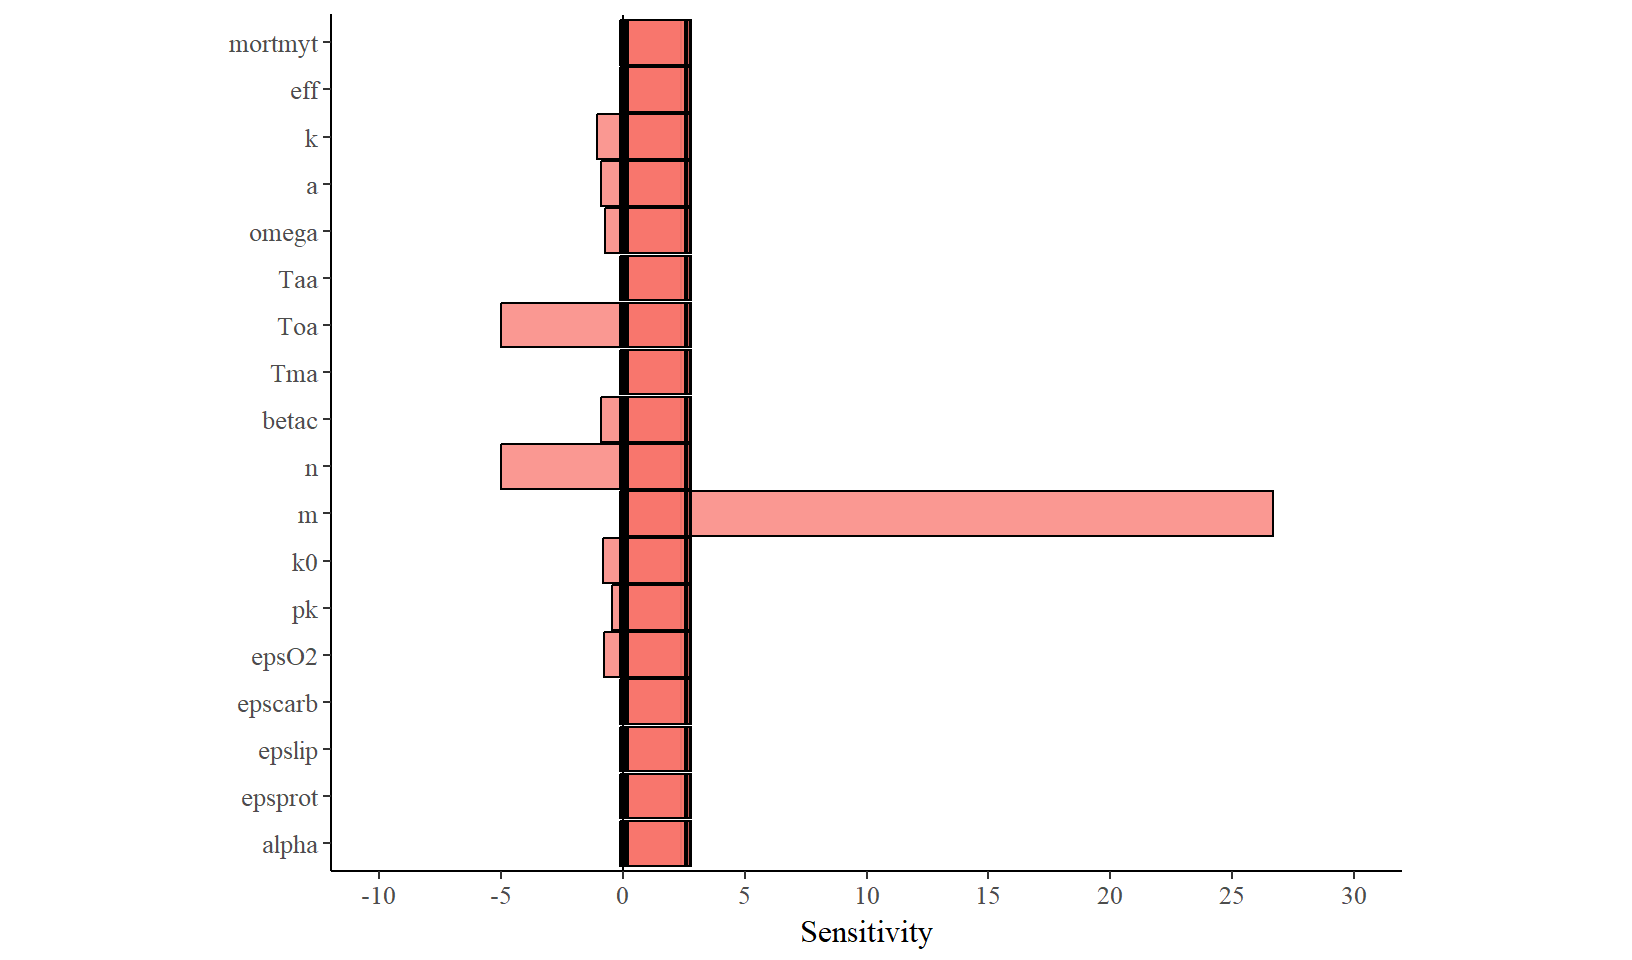

In [ ]:
sens_data <- sens_data %>% 
  filter(measure %in% c("total_excr", "total_uneat")) 

sens_data %>% 
  ggplot(aes(x = adj_param, y = mean_sens, ymin = mean_sens - sd_sens, ymax = mean_sens + sd_sens, fill = measure)) +
  geom_col(position = position_dodge(), width = 0.95, colour = "black", alpha = 0.75) +
  # geom_errorbar(position = position_dodge(width = 0.95), width = 0.3) +
  geom_hline(aes(yintercept = 0), linetype = "dashed") +
  scale_y_continuous(breaks = seq(-30,30,5), limits = c(-10,30)) +
  # scale_x_discrete(limits = rev(param_names$name), labels = rev(param_names$lab)) +
  # scale_fill_manual(values = c(total_excr = "salmon", total_uneat = "steelblue")) +
  labs(x = "Adjusted parameter", y = "Sensitivity") +
  prettyplot() +
  theme(strip.text = element_blank(), 
        aspect.ratio = 0.8,
        axis.title.y = element_blank()) +
  coord_flip()

# References